### Importing Libraries

In [52]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import sys, glob, time,re,string
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

### Loading The Dataset

In [2]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  iremmhatipoglu


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset


100%|██████████| 28.0M/28.0M [00:01<00:00, 18.0MB/s]


### Dataset Analysis

In [3]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


In [4]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


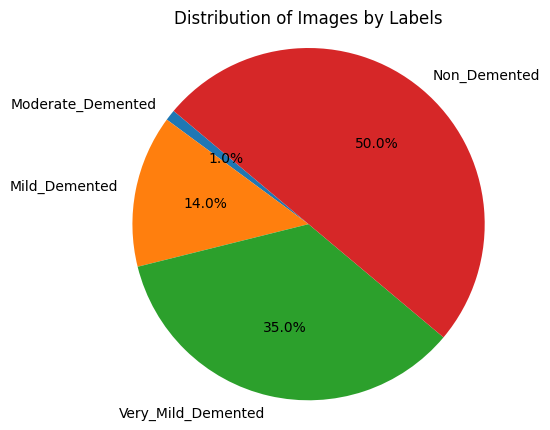

In [5]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [6]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

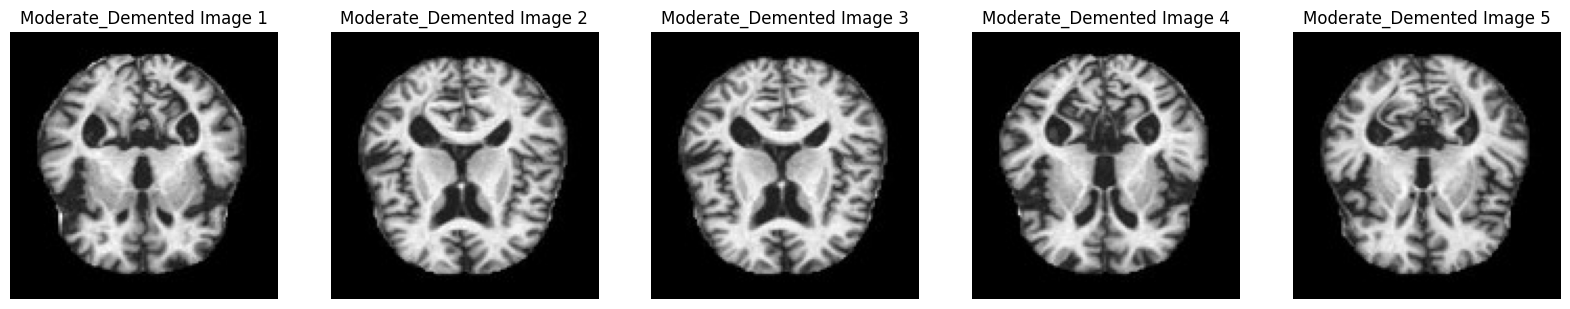

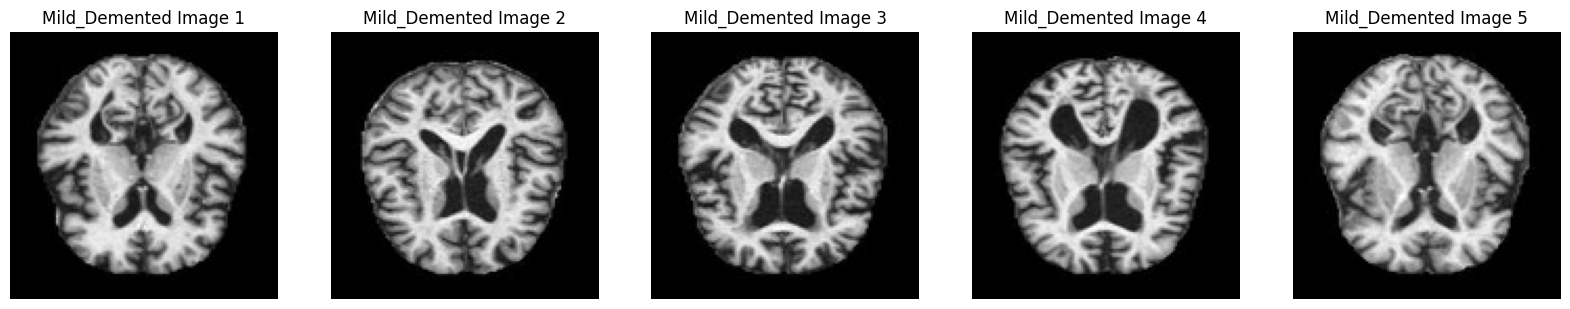

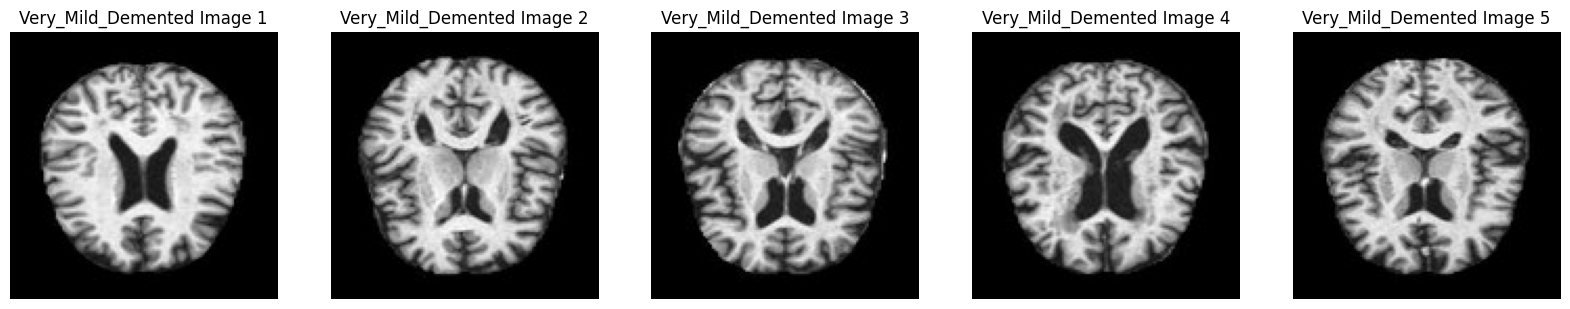

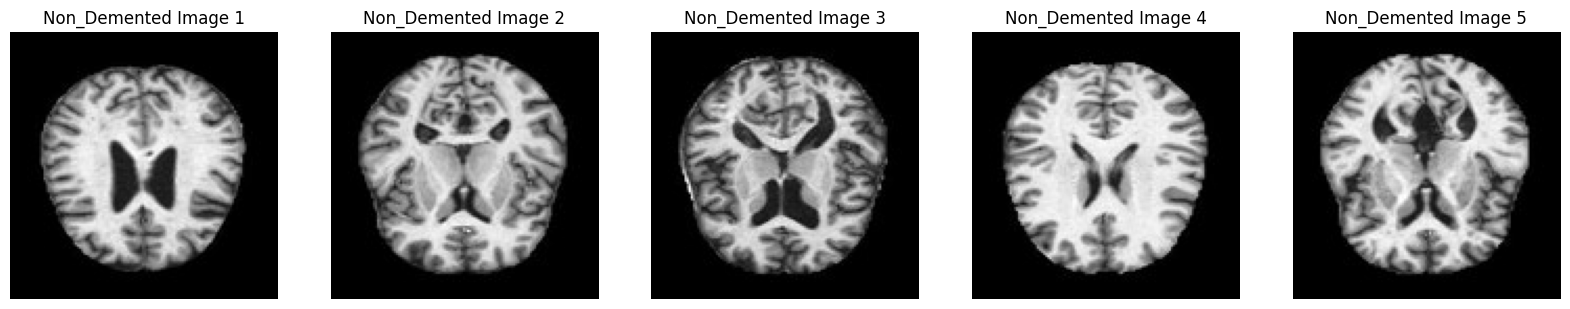

In [7]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

In [8]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [9]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


### Data Augmentation

In [10]:
#parameters
img_width, img_height = 128, 128
batch_size=32
latent_dim = 128
epochs = 60

In [11]:
#directories
img_generator = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)
#Main Data
dataset = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode='categorical'
)
#Moderate Data
moderate_demented = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    classes=['Moderate_Demented']
)

Found 6400 images belonging to 4 classes.
Found 64 images belonging to 1 classes.


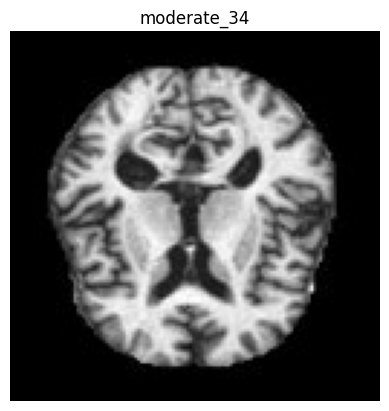

In [12]:
#Display random image from 'Moderate_Demented' class
moderate_dataset = os.path.join(dataset_dir, 'Moderate_Demented')
moderate_images = os.listdir(moderate_dataset)

img_name = np.random.choice(moderate_images)
img_path = os.path.join(moderate_dataset, img_name)

img = plt.imread(img_path)
img_name = os.path.splitext(img_name)[0]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(img_name)
plt.show()

Found 6400 files belonging to 4 classes.


2024-07-02 10:39:23.845918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2024-07-02 10:39:23.846049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2024-07-02 10:39:23.877274: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


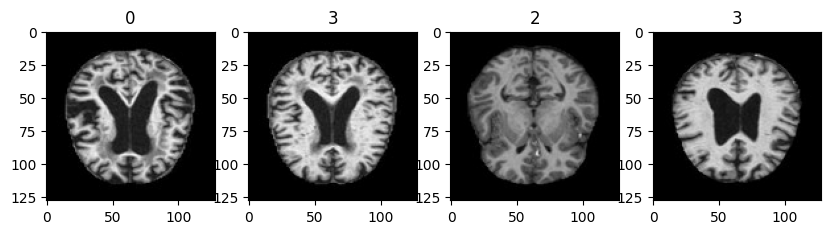

In [13]:
dataset_train = keras. utils.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = (img_width, img_height))

data_iterator = dataset_train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
train_gen = img_generator.flow_from_directory(
        dataset_dir,
        target_size = (64, 64),
        batch_size = batch_size,
        class_mode = None)

Found 6400 images belonging to 4 classes.


In [15]:
#Generator
def generator_model():
    generator = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return generator

generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [16]:
#Discriminator
def discriminator_model():
    discriminator = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

In [17]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        # loss metrics
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')


    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    
        generated_images = self.generator(random_latent_vectors)
    
        combined_images = tf.concat([generated_images, real_images], axis=0)
    
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))  # Adding noise to labels

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}


In [18]:
#Monitor and saving images
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128, num_images=10, output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented'):
        self.latent_dim = latent_dim
        self.num_images = num_images
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_images, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_images):
            img = keras.utils.array_to_img(generated_images[i])
            img_path = os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png")
            img.save(img_path)

In [19]:
dcgan_monitor = DCGANMonitor(output_dir='./alzheimer-mri-dataset/Dataset/Moderate_Demented')

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim)
dcgan.compile(g_optimizer = Adam (learning_rate= 0.0001, beta_1= 0.0001), d_optimizer= Adam (learning_rate = 0.0001 , beta_1= 0.0001), loss_fn = BinaryCrossentropy())

# fit the model and save the history
history = dcgan.fit(train_gen, epochs=epochs, callbacks=[DCGANMonitor()])

Epoch 1/60


2024-07-02 10:39:24.263842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - 95s 473ms/step - d_loss: 0.3682 - g_loss: 1.3729
Epoch 2/60
200/200 [==============================] - 94s 468ms/step - d_loss: 0.4579 - g_loss: 1.3756
Epoch 3/60
200/200 [==============================] - 93s 467ms/step - d_loss: 0.6170 - g_loss: 0.9927
Epoch 4/60
200/200 [==============================] - 98s 489ms/step - d_loss: 0.6729 - g_loss: 0.8160
Epoch 5/60
200/200 [==============================] - 92s 457ms/step - d_loss: 0.6748 - g_loss: 0.8051
Epoch 6/60
200/200 [==============================] - 92s 462ms/step - d_loss: 0.6706 - g_loss: 0.8058
Epoch 7/60
200/200 [==============================] - 91s 455ms/step - d_loss: 0.6752 - g_loss: 0.7867
Epoch 8/60
200/200 [==============================] - 90s 451ms/step - d_loss: 0.6753 - g_loss: 0.7876
Epoch 9/60
200/200 [==============================] - 91s 453ms/step - d_loss: 0.6722 - g_loss: 0.7908
Epoch 10/60
200/200 [==============================] - 91s 453ms/step - d_loss: 0.67

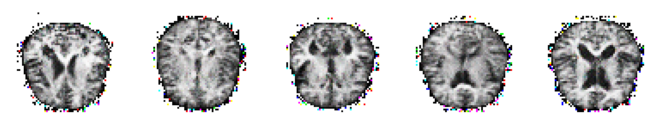

In [20]:
plt.figure(figsize=(10, 10))

for i in range(5):
    plt.subplot(6, 6, i + 1)
    noise = tf.random.normal([1, 128])
    mg = dcgan.generator(noise)
    
    #denormalize
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

In [21]:
#To balance the dataset deleting the images from some folders
def delete_images(label_dir, num_images):
   
    images = os.listdir(label_dir)
    num_images = min(num_images, len(images))

    images_to_delete = random.sample(images, num_images)
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Very_Mild_Demented")

num_delete_nd = 2000
num_delete_vmd = 1000
delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)

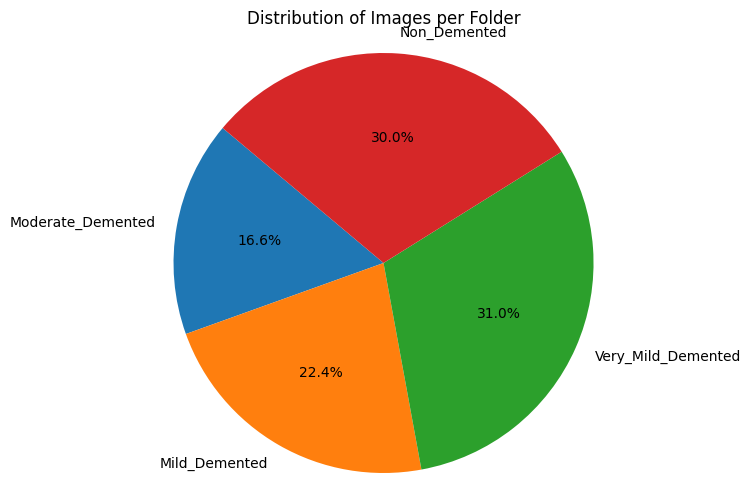

Number of Images in Each Folder:
Moderate_Demented: 664 images
Mild_Demented: 896 images
Very_Mild_Demented: 1240 images
Non_Demented: 1200 images


In [22]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

In [23]:
#Create dataframe from the dataset
def create_dataframe(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                data.append({'image_path': image_path, 'label': label})
    df = pd.DataFrame(data)
    return df

In [24]:
dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm

,image_path,label
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
...,...,...
3995,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
3996,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
3997,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
3998,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented


In [25]:
#Function for calculate GLCM features
def calculate_glcm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    #properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, dissimilarity, homogeneity, energy, correlation

In [26]:
def df_with_glcm(df):

    glcm_properties = df['image_path'].apply(calculate_glcm)
    df[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] = pd.DataFrame(glcm_properties.tolist(), index=df.index)
    return df

dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm = df_with_glcm(df_glcm)
df_glcm

,image_path,label,contrast,dissimilarity,homogeneity,energy,correlation
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,927.474206,16.930556,0.456542,0.431909,0.938679
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,1121.253968,18.477679,0.448929,0.407292,0.918034
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,890.730655,16.414683,0.455439,0.419246,0.929277
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,1150.954861,18.217262,0.453848,0.417266,0.922400
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,1313.499504,19.960317,0.462561,0.435199,0.904058
...,...,...,...,...,...,...,...
3995,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,288.036663,8.844857,0.488142,0.417868,0.982065
3996,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,305.834031,9.303888,0.456331,0.389942,0.979521
3997,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,304.958169,9.322096,0.456292,0.391376,0.979809
3998,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,355.366880,9.789493,0.456729,0.390447,0.974058


In [27]:
X = df_glcm.iloc[:,2:7]
y = df_glcm['label']

X

,contrast,dissimilarity,homogeneity,energy,correlation
0,927.474206,16.930556,0.456542,0.431909,0.938679
1,1121.253968,18.477679,0.448929,0.407292,0.918034
2,890.730655,16.414683,0.455439,0.419246,0.929277
3,1150.954861,18.217262,0.453848,0.417266,0.922400
4,1313.499504,19.960317,0.462561,0.435199,0.904058
...,...,...,...,...,...
3995,288.036663,8.844857,0.488142,0.417868,0.982065
3996,305.834031,9.303888,0.456331,0.389942,0.979521
3997,304.958169,9.322096,0.456292,0.391376,0.979809
3998,355.366880,9.789493,0.456729,0.390447,0.974058


In [53]:
#Machine Learning function
def ml_models(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time

# Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    accuracy = classification_report(y_test, y_pred)
    print("classification_report:", accuracy)

    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {predict_time:.4f} seconds")

# Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix')
    plt.show()

Accuracy: 0.645
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.54      0.58      0.56       189
 Moderate_Demented       1.00      0.91      0.95       147
      Non_Demented       0.64      0.62      0.63       218
Very_Mild_Demented       0.54      0.55      0.55       246

          accuracy                           0.65       800
         macro avg       0.68      0.67      0.67       800
      weighted avg       0.65      0.65      0.65       800

Training Time: 0.9674 seconds
Prediction Time: 0.0280 seconds


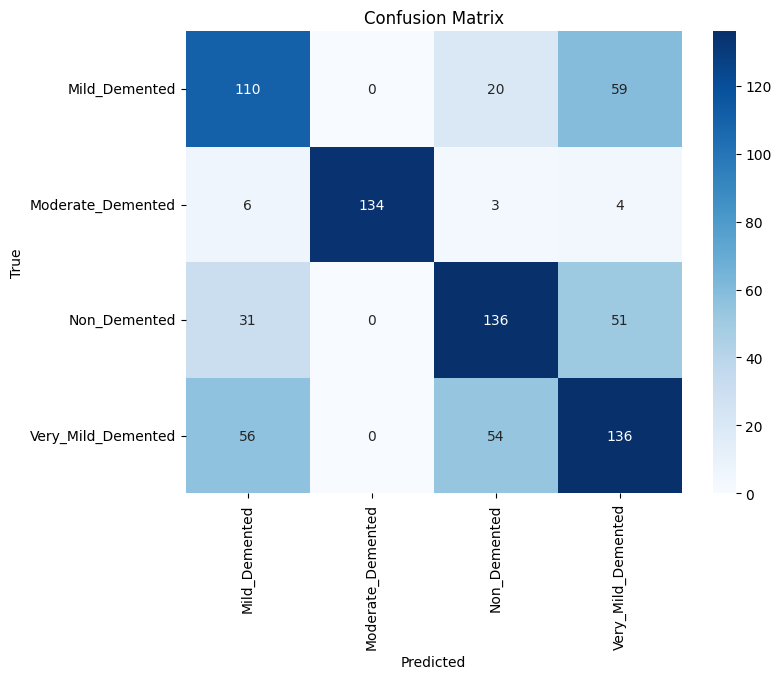

In [54]:
#RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=300)
ml_models(rf_model, X, y)

In [59]:
def get_images(directory):
    Images = []
    Labels = []
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

In [42]:
#Train data
Images, Labels = get_images("./alzheimer-mri-dataset/Dataset/") #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [43]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(Labels)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [45]:
from collections import Counter
Counter(encoded_labels)

Counter({3: 1240, 2: 1200, 0: 896, 1: 664})

### Deep Learning

In [61]:
#Function for deep learning approaches
def deep_learning(base_model, input_shape=(128, 128, 3), num_classes=4):
    model = Sequential()
    model.add(base_model(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [65]:
#EfficientNetB0
efficientnet_model = deep_learning(EfficientNetB0)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
start_time_effnet = time.time()
training_history_eff = efficientnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)
train_time_effnet = time.time() - start_time_effnet

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_6 (Flatten)         (None, 20480)             0         
                                                                 
 dense_32 (Dense)            (None, 4096)              83890176  
                                                                 
 dense_33 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_34 (Dense)            (None, 256)               262400    
                                                                 
 dense_35 (Dense)            (None, 64)                16448     
                                                                 
 dense_36 (Dense)            (None, 32)               

Epoch 1/100
100/100 [==============================] - 30s 281ms/step - loss: 0.9486 - accuracy: 0.5337 - val_loss: 0.8858 - val_accuracy: 0.5688
Epoch 2/100
100/100 [==============================] - 26s 260ms/step - loss: 0.8510 - accuracy: 0.5916 - val_loss: 1.0436 - val_accuracy: 0.5700
Epoch 3/100
100/100 [==============================] - 28s 276ms/step - loss: 0.7971 - accuracy: 0.6256 - val_loss: 0.7897 - val_accuracy: 0.6463
Epoch 4/100
100/100 [==============================] - 27s 272ms/step - loss: 0.7407 - accuracy: 0.6584 - val_loss: 0.7823 - val_accuracy: 0.6575
Epoch 5/100
100/100 [==============================] - 28s 283ms/step - loss: 0.7200 - accuracy: 0.6822 - val_loss: 0.7231 - val_accuracy: 0.6775
Epoch 6/100
100/100 [==============================] - 30s 297ms/step - loss: 0.6767 - accuracy: 0.6897 - val_loss: 0.6991 - val_accuracy: 0.6850
Epoch 7/100
100/100 [==============================] - 29s 292ms/step - loss: 0.6411 - accuracy: 0.7159 - val_loss: 0.7505 -

25/25 [==============================] - 4s 131ms/step
F1 Score: 0.8799200572446891
Recall: 0.88
Precision: 0.8883441626756178
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       151
           1       0.99      1.00      1.00       132
           2       0.93      0.81      0.86       260
           3       0.87      0.83      0.85       257

    accuracy                           0.88       800
   macro avg       0.89      0.91      0.89       800
weighted avg       0.89      0.88      0.88       800

Training Time: 2688.9872279167175
Prediction Time: 3.7761521339416504


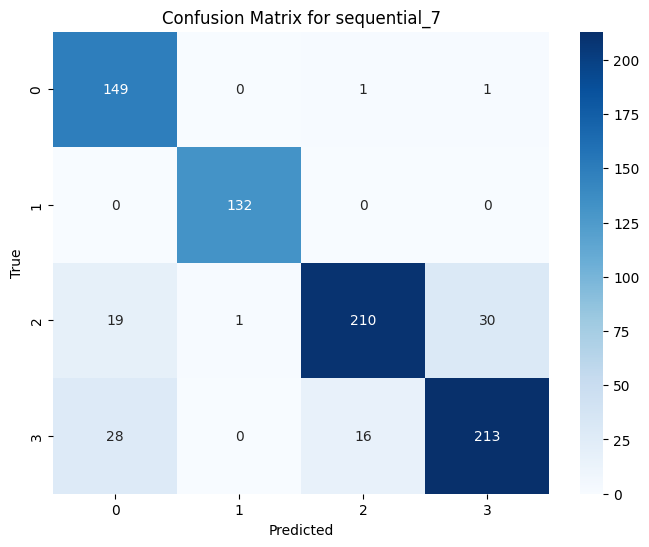

In [66]:
start_time_effnet = time.time()
y_pred = np.argmax(efficientnet_model.predict(X_test), axis=1)
predict_time_effnet = time.time() - start_time_effnet

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_effnet)
print("Prediction Time:", predict_time_effnet)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {efficientnet_model.name}')
plt.show()

In [67]:
#VGG16
vgg_model = deep_learning(VGG16)
vgg_model.summary()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
start_time_vgg = time.time()
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)
train_time_vgg = time.time() - start_time_vgg

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_38 (Dense)            (None, 4096)              33558528  
                                                                 
 dense_39 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_40 (Dense)            (None, 256)               262400    
                                                                 
 dense_41 (Dense)            (None, 64)                16448     
                                                                 
 dense_42 (Dense)            (None, 32)               

Epoch 1/100
100/100 [==============================] - 117s 1s/step - loss: 1.2833 - accuracy: 0.5506 - val_loss: 1.0422 - val_accuracy: 0.6025
Epoch 2/100
100/100 [==============================] - 112s 1s/step - loss: 0.6524 - accuracy: 0.7212 - val_loss: 0.6757 - val_accuracy: 0.7075
Epoch 3/100
100/100 [==============================] - 111s 1s/step - loss: 0.5252 - accuracy: 0.7778 - val_loss: 0.6050 - val_accuracy: 0.7475
Epoch 4/100
100/100 [==============================] - 113s 1s/step - loss: 0.3818 - accuracy: 0.8506 - val_loss: 0.5213 - val_accuracy: 0.7937
Epoch 5/100
100/100 [==============================] - 111s 1s/step - loss: 0.2517 - accuracy: 0.9038 - val_loss: 0.5839 - val_accuracy: 0.7750
Epoch 6/100
100/100 [==============================] - 111s 1s/step - loss: 0.1895 - accuracy: 0.9319 - val_loss: 0.5173 - val_accuracy: 0.8200
Epoch 7/100
100/100 [==============================] - 123s 1s/step - loss: 0.0813 - accuracy: 0.9766 - val_loss: 0.4540 - val_accuracy:

25/25 [==============================] - 24s 976ms/step
F1 Score: 0.8999107712986458
Recall: 0.9
Precision: 0.9041661739165029
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       151
           1       0.99      0.96      0.98       132
           2       0.94      0.83      0.88       260
           3       0.84      0.89      0.87       257

    accuracy                           0.90       800
   macro avg       0.91      0.92      0.91       800
weighted avg       0.90      0.90      0.90       800

Training Time: 13911.737814188004
Prediction Time: 24.460231065750122


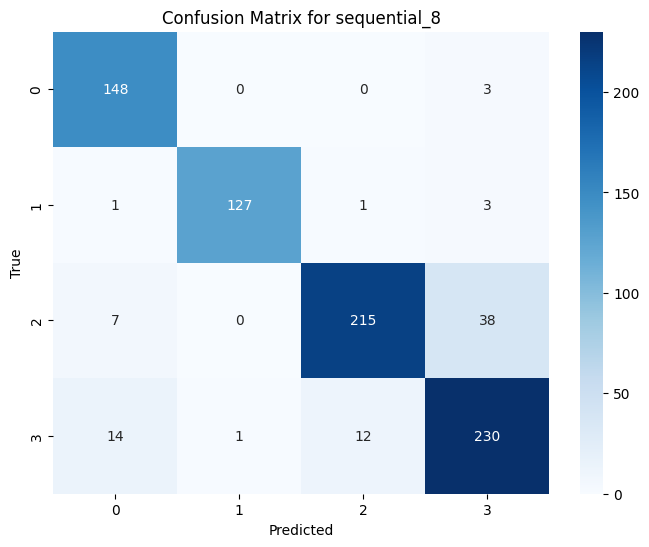

In [68]:
start_time_vgg = time.time()
y_pred = np.argmax(vgg_model.predict(X_test), axis=1)
predict_time_vgg = time.time() - start_time_vgg

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_vgg)
print("Prediction Time:", predict_time_vgg)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {vgg_model.name}')
plt.show()

In [69]:
#ResNet50
resnet_model = deep_learning(ResNet50)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
start_time_resnet = time.time()
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)
train_time_resnet = time.time() - start_time_resnet

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_44 (Dense)            (None, 4096)              134221824 
                                                                 
 dense_45 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_46 (Dense)            (None, 256)               262400    
                                                                 
 dense_47 (Dense)            (None, 64)                16448     
                                                                 
 dense_48 (Dense)            (None, 32)               

Epoch 1/100
100/100 [==============================] - 1989s 20s/step - loss: 1.0366 - accuracy: 0.5350 - val_loss: 0.9005 - val_accuracy: 0.5987
Epoch 2/100
100/100 [==============================] - 996s 10s/step - loss: 0.8289 - accuracy: 0.6241 - val_loss: 0.8145 - val_accuracy: 0.6212
Epoch 3/100
100/100 [==============================] - 69s 687ms/step - loss: 0.6897 - accuracy: 0.7025 - val_loss: 0.8127 - val_accuracy: 0.6325
Epoch 4/100
100/100 [==============================] - 69s 687ms/step - loss: 0.5255 - accuracy: 0.7853 - val_loss: 0.6585 - val_accuracy: 0.7312
Epoch 5/100
100/100 [==============================] - 63s 630ms/step - loss: 0.4213 - accuracy: 0.8228 - val_loss: 0.5602 - val_accuracy: 0.7725
Epoch 6/100
100/100 [==============================] - 622s 6s/step - loss: 0.3372 - accuracy: 0.8666 - val_loss: 0.6149 - val_accuracy: 0.7425
Epoch 7/100
100/100 [==============================] - 55s 552ms/step - loss: 0.2671 - accuracy: 0.9016 - val_loss: 0.6874 - va

25/25 [==============================] - 8s 321ms/step
F1 Score: 0.8770614921853246
Recall: 0.87625
Precision: 0.8805722584328666
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84       151
           1       1.00      0.97      0.98       132
           2       0.92      0.84      0.88       260
           3       0.84      0.84      0.84       257

    accuracy                           0.88       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.88      0.88      0.88       800

Training Time: 9876.381811380386
Prediction Time: 8.483378887176514


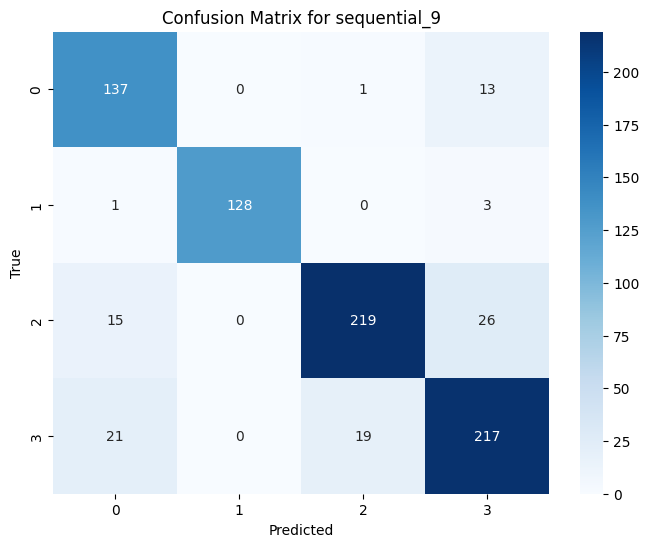

In [70]:
start_time_resnet = time.time()
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)
predict_time_resnet = time.time() - start_time_resnet

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_resnet)
print("Prediction Time:", predict_time_resnet)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {resnet_model.name}')
plt.show()

In [72]:
training_histories = {
    'VGG16': training_history_vgg,
    'ResNet50': training_history_resnet,
    'EfficientNetB0': training_history_eff
}

In [73]:
def plot_training_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 8))
    
    for model, history in histories.items():
        plt.plot(history.history[metric], label=f'{model} Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'{model} Validation {metric.capitalize()}')

    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

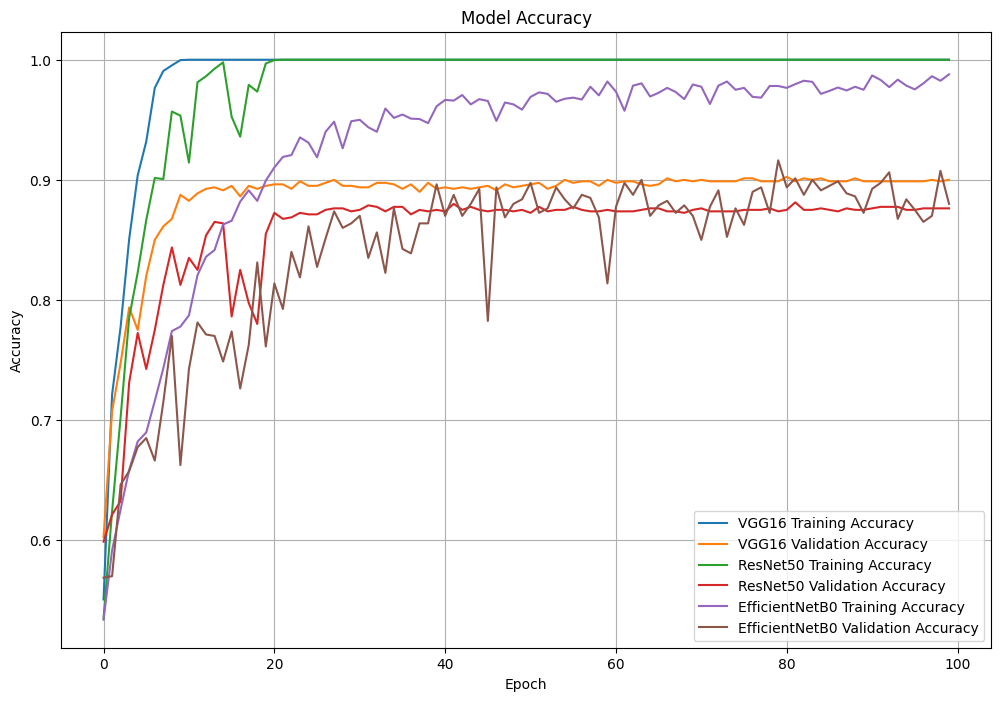

In [74]:
plot_training_history(training_histories, metric='accuracy')

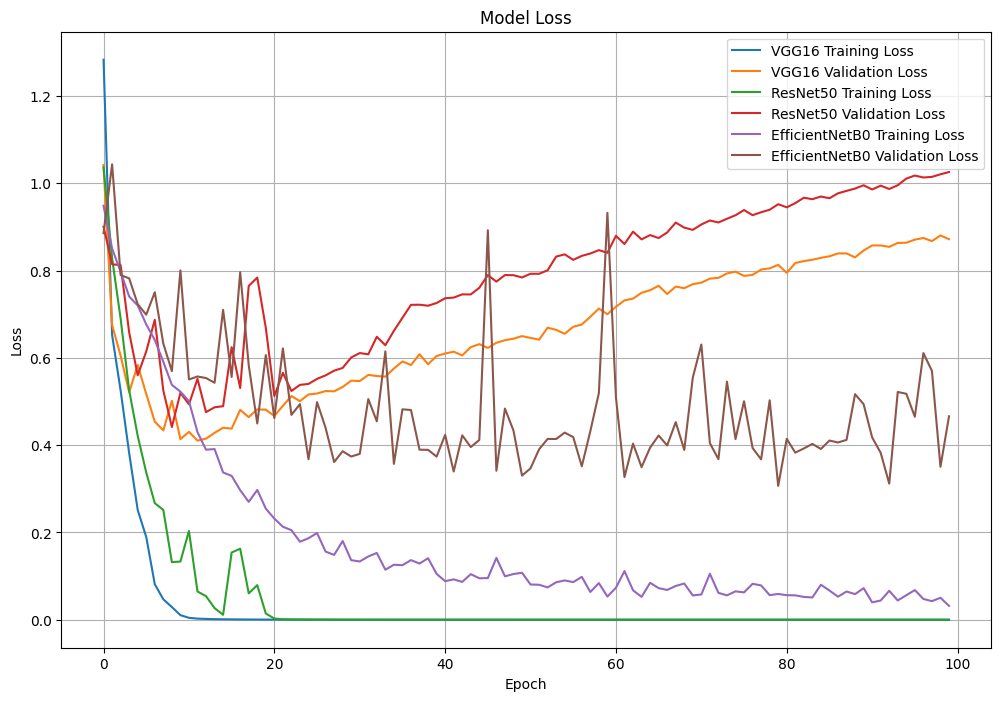

In [75]:
plot_training_history(training_histories, metric='loss')

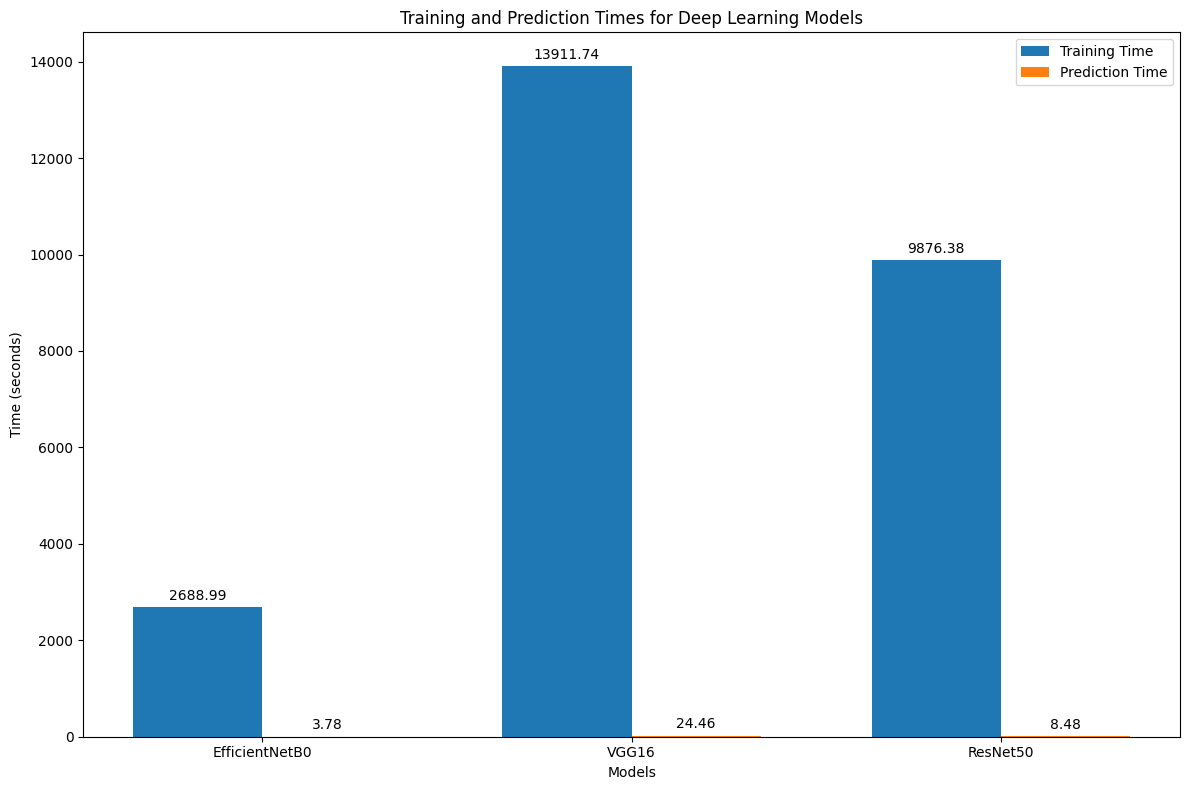

In [83]:
dl_models_names = ['EfficientNetB0', 'VGG16', 'ResNet50']
train_times = [train_time_effnet, train_time_vgg, train_time_resnet]
predict_times = [predict_time_effnet, predict_time_vgg, predict_time_resnet]

x = np.arange(len(dl_models_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width/2, train_times, width, label='Training Time')
rects2 = ax.bar(x + width/2, predict_times, width, label='Prediction Time')

ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Prediction Times for Deep Learning Models')
ax.set_xticks(x)
ax.set_xticklabels(dl_models_names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()